In [1]:
import sympy as sp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

sp.init_printing(use_latex='mathjax') 

## La Perte de Huber

La Perte de Huber est une fonction de perte hybride, moins sensible aux valeurs extrêmes que l'Erreur Quadratique Moyenne (MSE). Elle agit comme la MAE pour les erreurs importantes et comme la MSE pour les petites erreurs.

La Perte de Huber $\mathcal{L}_\delta(e)$, pour une erreur $e = (y - \hat{y})$ et un seuil $\delta > 0$, est définie par morceaux :

$$
\mathcal{L}_{\delta}(e) =
\begin{cases}
\tfrac{1}{2} e^2 & \text{si } |e| \le \delta \\
\delta (|e| - \tfrac{1}{2}\delta) & \text{si } |e| > \delta
\end{cases}
$$

Elle combine MSE (pour petites erreurs) et MAE (pour grandes erreurs).

In [2]:
e, delta = sp.symbols('e delta', real=True, positive=True)

# Définition symbolique de la Perte de Huber (en fonction de l'erreur e)
L_Huber_symbolic = sp.Piecewise(
    (sp.Rational(1, 2) * e**2, sp.Abs(e) <= delta),  # Région Quadratique
    (delta * (sp.Abs(e) - sp.Rational(1, 2) * delta), sp.Abs(e) > delta) # Région Linéaire
)

L_Huber_symbolic

⎧     2                
⎪    e                 
⎪    ──       for δ ≥ e
⎪    2                 
⎨                      
⎪  ⎛  δ    ⎞           
⎪δ⋅⎜- ─ + e⎟  otherwise
⎪  ⎝  2    ⎠           
⎩                      

### 1) Calcul du gradient de la fonction

Le gradient est essentiel pour la descente de gradient.

In [3]:
# Calcul du gradient de la Perte de Huber par rapport à l'erreur 'e' en utilisant sympy
grad_Huber_symbolic = sp.diff(L_Huber_symbolic, e)

grad_Huber_symbolic

⎧e  for δ ≥ e
⎨            
⎩δ  otherwise

le gradient de la fonction est donc:

$$
\nabla\mathcal{L}_{\delta}(e) =
\begin{cases}
e & \text{si } |e| \le \delta \\
\delta \cdot \text{sgn}(e) & \text{si } |e| > \delta
\end{cases}
$$

Le gradient est plafonné, ce qui limite l’influence des outliers.

### 2) Convexité de la Perte de Huber
On étudie la dérivée seconde :

In [4]:
hessian_Huber_symbolic = sp.diff(grad_Huber_symbolic, e)
hessian_Huber_symbolic

⎧1  for δ ≥ e
⎨            
⎩0  otherwise

Le resultat de la derivee seconde est donc:
$$
\nabla^2\mathcal{L}_{\delta}(e) =
\begin{cases}
1 & \text{si } |e| < \delta \\
0 & \text{si } |e| > \delta
\end{cases}
$$

Comme la dérivée seconde est $\geq 0$ partout, la Perte de Huber est convexe.
Cela garantit une convergence vers un minimum global avec la descente de gradient.

### 3) a) Application & visualisation

In [ ]:
# Chargement des donnees
try:
    df_reg = pd.read_csv('data/regression_data.csv')
    X = df_reg[['X1', 'X2']].values
    Y = df_reg['Y_Cible'].values
except FileNotFoundError:
    print("Le fichier des donnees n'est pas charge")

print(f"Données de régression chargées : {X.shape} attributs et {Y.shape} cibles.")

Données de régression chargées : (70, 2) attributs et (70,) cibles.


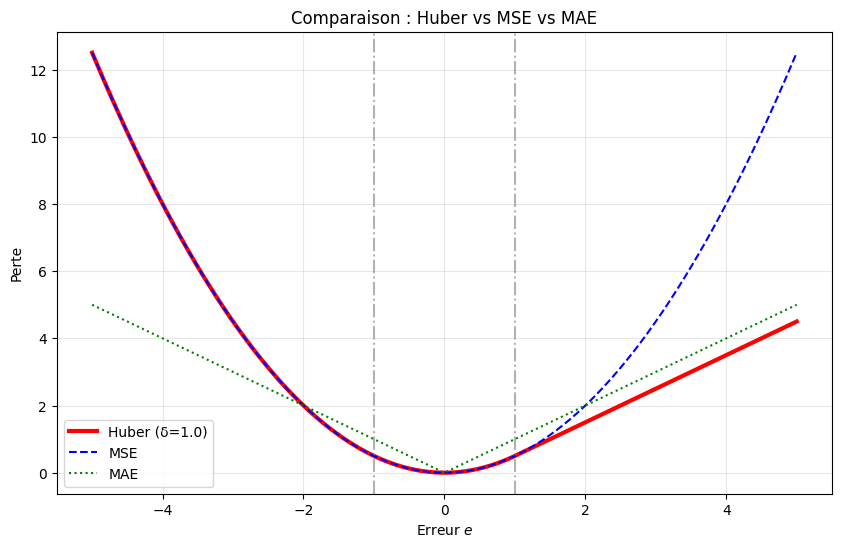

In [6]:
delta_numeric = 1.0
huber_func = sp.lambdify(e, L_Huber_symbolic.subs(delta, delta_numeric), 'numpy')

e_vals = np.linspace(-5, 5, 200)
huber_vals = huber_func(e_vals)
mae_vals = np.abs(e_vals)
mse_vals = 0.5 * e_vals**2

plt.figure(figsize=(10, 6))
plt.plot(e_vals, huber_vals, label=f'Huber (δ={delta_numeric})', color='red', linewidth=3)
plt.plot(e_vals, mse_vals, '--', label='MSE', color='blue')
plt.plot(e_vals, mae_vals, ':', label='MAE', color='green')
plt.axvline(x=delta_numeric, color='gray', linestyle='-.', alpha=0.6)
plt.axvline(x=-delta_numeric, color='gray', linestyle='-.', alpha=0.6)
plt.title("Comparaison : Huber vs MSE vs MAE")
plt.xlabel("Erreur $e$")
plt.ylabel("Perte")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


On voit que :

Pour petites erreurs → Huber ≈ MSE

Pour grandes erreurs → Huber ≈ MAE

Transition lisse autour de $|e| = \delta$.

### 3) b) Tangente à la Courbe de Huber

On cherche l’équation de la tangente en $e_0 = 0.5$ avec $\delta = 1$.

In [7]:
e0_val, delta_val = 0.5, 1.0

pente_m = grad_Huber_symbolic.subs({e: e0_val, delta: delta_val})
perte_e0 = L_Huber_symbolic.subs({e: e0_val, delta: delta_val})

T_e_symbolic = perte_e0 + pente_m * (e - e0_val)
T_e_symbolic


0.5⋅e - 0.125

La formule generale de la tangente sera donc:

$$
T(e) = \mathcal{L}_{\delta}(e_0) + \nabla\mathcal{L}_{\delta}(e_0)(e - e_0)
$$

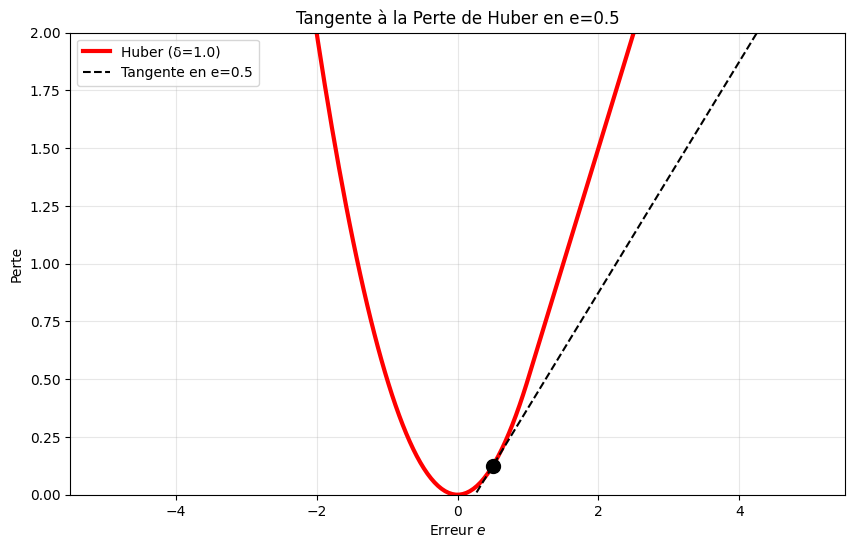

In [8]:
tangent_func = sp.lambdify(e, T_e_symbolic.subs(delta, delta_val), 'numpy')

plt.figure(figsize=(10, 6))
plt.plot(e_vals, huber_func(e_vals), label=f'Huber (δ={delta_val})', color='red', linewidth=3)
plt.plot(e_vals, tangent_func(e_vals), '--', label=f'Tangente en e={e0_val}', color='black')
plt.scatter(e0_val, perte_e0, color='black', s=100, zorder=5)
plt.title(f"Tangente à la Perte de Huber en e={e0_val}")
plt.xlabel("Erreur $e$")
plt.ylabel("Perte")
plt.ylim(0, 2)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
